In [2]:
import pyedflib
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.signal import find_peaks, lfilter
import neurokit2 as nk

In [3]:
data_dir = '../data/raw'
record_name = 'r01.edf'
record_path = os.path.join(data_dir, record_name)

In [4]:
try:
    f = pyedflib.EdfReader(record_path)

    n_channels = f.signals_in_file
    ch_names = f.getSignalLabels()
    fs = int(f.getSampleFrequency(0)) # Get sample freq of the first channel
    n_samples_total = f.getNSamples()[0] # Get number of samples in the first channel

    print("\nSuccessfully opened EDF data file.")
    print(f"Number of channels: {n_channels}")
    print(f"Channel names: {ch_names}")
    print(f"Sampling frequency: {fs} Hz")
    print(f"Total samples per channel: {n_samples_total}")

    signals_list = [f.readSignal(i) for i in range(n_channels)]
    signals = np.array(signals_list).T # (samples, channels)
    f.close()

    try:
        maternal_ecg_channel_index = ch_names.index('Abdomen_1')
    except ValueError:
        print("Warning: 'Abdomen_1' channel not found. Please identify the correct channel name.")
        maternal_ecg_channel_index = 0
        print(f"Using channel {maternal_ecg_channel_index} ('{ch_names[maternal_ecg_channel_index]}') as the raw signal.")

    raw_signal = signals[:, maternal_ecg_channel_index]
    sampling_rate = fs
    time = np.linspace(0, len(raw_signal)/sampling_rate, len(raw_signal), endpoint=False)

    print(f"Selected channel for processing: '{ch_names[maternal_ecg_channel_index]}'")
    print(f"Loaded signal with {len(raw_signal)} samples at {sampling_rate} Hz.")

except Exception as e:
    print(f"Error loading EDF file: {e}")
    raw_signal = None
    sampling_rate = None


Successfully opened EDF data file.
Number of channels: 5
Channel names: ['Direct_1', 'Abdomen_1', 'Abdomen_2', 'Abdomen_3', 'Abdomen_4']
Sampling frequency: 1000 Hz
Total samples per channel: 300000
Selected channel for processing: 'Abdomen_1'
Loaded signal with 300000 samples at 1000 Hz.


In [7]:
signals_dict = nk.ecg_process(signals_list, sampling_rate=sampling_rate, method="neurokit2")
nk.ecg_plot(signals_dict)

ValueError: NeuroKit error: we expect the user to provide a vector, i.e., a one-dimensional array (such as a list of values). Current input of shape: (5, 300000)

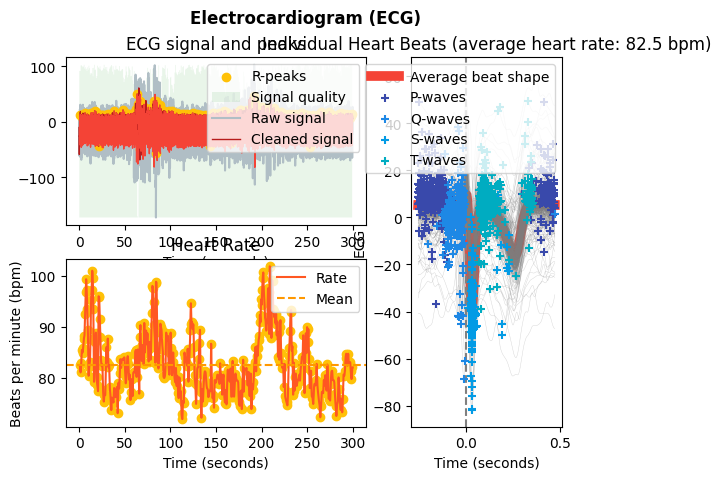

In [ ]:
signals, info = nk.ecg_process(raw_signal, sampling_rate=1000)
nk.ecg_plot(signals, info)

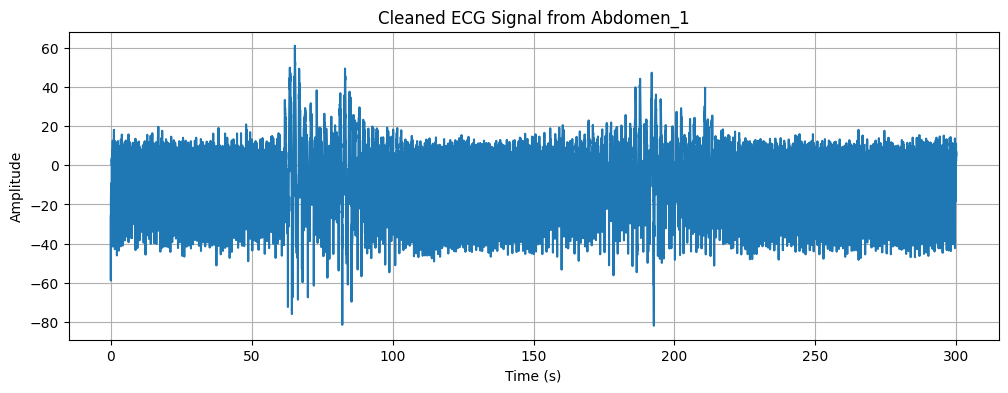

In [ ]:
clean_signal = nk.ecg_clean(raw_signal, sampling_rate=sampling_rate)
# Plot the cleaned signal
plt.figure(figsize=(12, 4))
plt.plot(time, clean_signal)
plt.title(f'Cleaned ECG Signal from {ch_names[maternal_ecg_channel_index]}')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

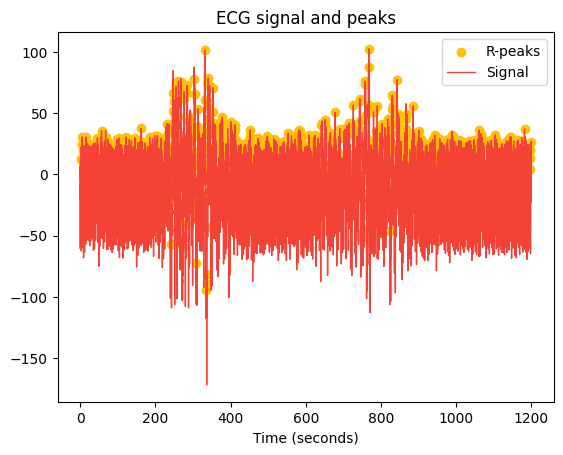

In [ ]:
signals, info = nk.ecg_peaks(raw_signal, sampling_rate=250, correct_artifacts=True, show=True)

In [ ]:
qrs_epochs = nk.ecg_segment(raw_signal, rpeaks=None, sampling_rate=1000, show=False)

In [ ]:
print(type(qrs_epochs))
print(f"Number of epochs: {len(qrs_epochs)}")
print(f"Keys (epoch labels): {list(qrs_epochs.keys())[:10]} ...")  # show first 10 keys

# Show info for the first epoch
first_key = list(qrs_epochs.keys())[0]
print(f"\nFirst epoch key: {first_key}")
print(qrs_epochs[first_key].info())
print(qrs_epochs[first_key].head())

# Build a matrix of signals from all epochs (each column is an epoch)
epoch_keys = list(qrs_epochs.keys())
num_epochs = len(epoch_keys)
epoch_length = qrs_epochs[epoch_keys[0]].shape[0]

# Preallocate matrix
signals_matrix = np.zeros((epoch_length, num_epochs))

for i, key in enumerate(epoch_keys):
    signals_matrix[:, i] = qrs_epochs[key]['Signal'].values

print(f"signals_matrix shape: {signals_matrix.shape}")

<class 'dict'>
Number of epochs: 414
Keys (epoch labels): [np.str_('1'), np.str_('2'), np.str_('3'), np.str_('4'), np.str_('5'), np.str_('6'), np.str_('7'), np.str_('8'), np.str_('9'), np.str_('10')] ...

First epoch key: 1
<class 'pandas.core.frame.DataFrame'>
Index: 725 entries, -0.2536406246872058 to 0.4710468744190965
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Signal  725 non-null    float64
 1   Index   725 non-null    int64  
 2   Label   725 non-null    string 
dtypes: float64(1), int64(1), string(1)
memory usage: 22.7 KB
None
             Signal  Index Label
-0.253641  6.850105    429     1
-0.252640  6.950106    430     1
-0.251639  7.150109    431     1
-0.250638  7.050108    432     1
-0.249637  6.350097    433     1
signals_matrix shape: (725, 414)


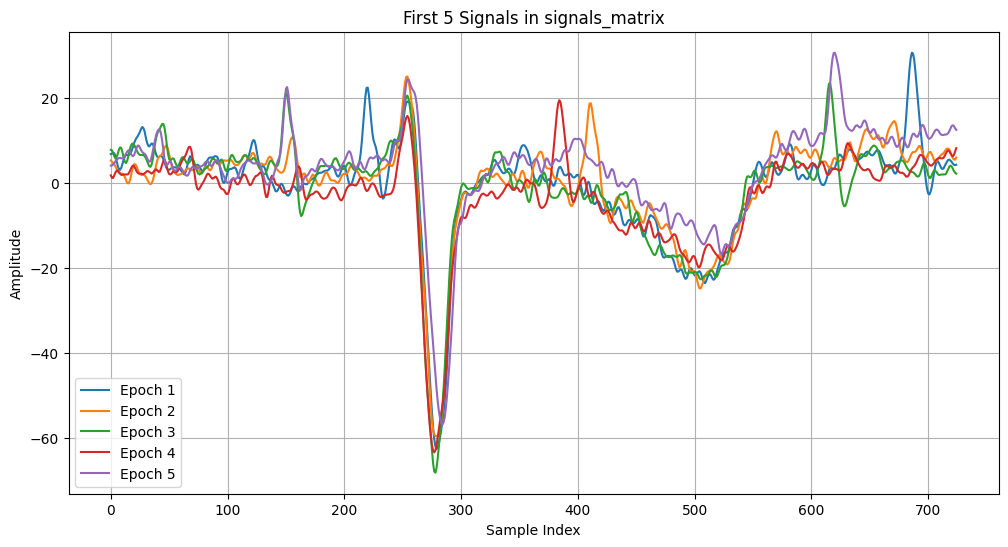

In [ ]:
plt.figure(figsize=(12, 6))
for idx in range(5):
    plt.plot(signals_matrix[:, idx], label=f'Epoch {idx+1}')
plt.title('First 5 Signals in signals_matrix')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()

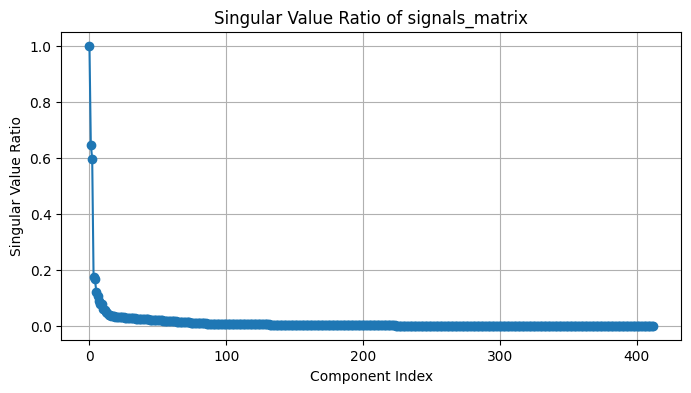

In [ ]:
# Remove columns with any NaN values before SVD
signals_matrix_clean = signals_matrix[:, ~np.isnan(signals_matrix).any(axis=0)]

# Perform Singular Value Decomposition (SVD) on the cleaned signals_matrix
U, S, VT = np.linalg.svd(signals_matrix_clean, full_matrices=False)

# Compute the singular value ratio (each singular value divided by the first)
singular_value_ratio = S / S[0]

# Plot the singular value ratio
plt.figure(figsize=(8, 4))
plt.plot(singular_value_ratio, marker='o')
plt.title('Singular Value Ratio of signals_matrix')
plt.xlabel('Component Index')
plt.ylabel('Singular Value Ratio')
plt.grid(True)
plt.show()

In [ ]:
# Extract the first singular vector and value
u1 = U[:, 0].reshape(-1, 1)           # (725, 1)
sigma1 = S[0]                         # scalar
v1T = VT[0, :].reshape(1, -1)         # (1, 413)

# Compute the rank-1 approximation: u1 * sigma1 * v1T
rank1_matrix = u1 @ (sigma1 * v1T)    # (725, 413)

# Remove the rank-1 component from the original matrix
signals_matrix_rank1_removed = signals_matrix_clean - rank1_matrix

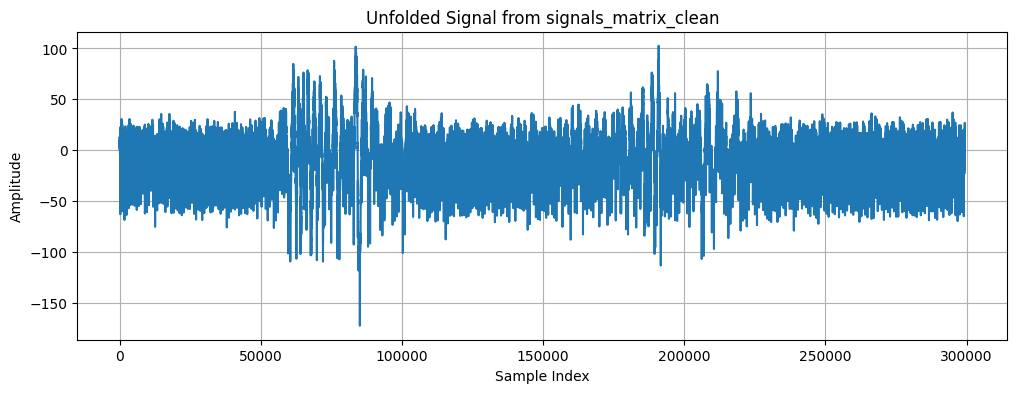

In [ ]:
# Unfold the signals_matrix (or signals_matrix_clean) by concatenating its columns to form a continuous time series
unfolded_signal = signals_matrix_clean.flatten(order='F')  # 'F' means column-major order

plt.figure(figsize=(12, 4))
plt.plot(unfolded_signal)
plt.title('Unfolded Signal from signals_matrix_clean')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

c:\Users\Ester\Desktop\ecg-svd\.venv\Lib\site-packages\neurokit2\signal\signal_fixpeaks.py:307: RuntimeWarning: divide by zero encountered in divide
  mrrs /= th2
c:\Users\Ester\Desktop\ecg-svd\.venv\Lib\site-packages\neurokit2\signal\signal_fixpeaks.py:307: RuntimeWarning: invalid value encountered in divide
  mrrs /= th2


<class 'dict'>
Number of epochs: 415
Keys (epoch labels): [np.str_('1'), np.str_('2'), np.str_('3'), np.str_('4'), np.str_('5'), np.str_('6'), np.str_('7'), np.str_('8'), np.str_('9'), np.str_('10')] ...

First epoch key: 1
<class 'pandas.core.frame.DataFrame'>
Index: 721 entries, -0.25233353359701394 to 0.4686194195373117
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Signal  721 non-null    float64
 1   Index   721 non-null    int64  
 2   Label   721 non-null    string 
dtypes: float64(1), int64(1), string(1)
memory usage: 22.5 KB
None
             Signal  Index Label
-0.252334  5.050077    726     1
-0.251332  4.750072    727     1
-0.250331  4.450068    728     1
-0.249330  3.950060    729     1
-0.248328  3.350051    730     1
signals_matrix shape: (721, 415)


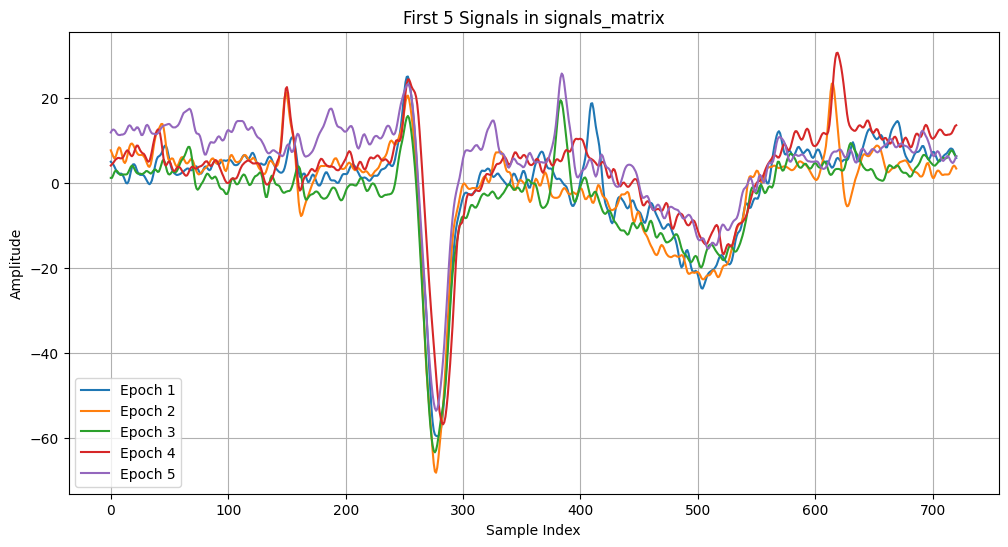

In [ ]:
qrs_epochs = nk.ecg_segment(unfolded_signal, rpeaks=None, sampling_rate=1000, show=False)

print(type(qrs_epochs))
print(f"Number of epochs: {len(qrs_epochs)}")
print(f"Keys (epoch labels): {list(qrs_epochs.keys())[:10]} ...")  # show first 10 keys

# Show info for the first epoch
first_key = list(qrs_epochs.keys())[0]
print(f"\nFirst epoch key: {first_key}")
print(qrs_epochs[first_key].info())
print(qrs_epochs[first_key].head())

# Build a matrix of signals from all epochs (each column is an epoch)
epoch_keys = list(qrs_epochs.keys())
num_epochs = len(epoch_keys)
epoch_length = qrs_epochs[epoch_keys[0]].shape[0]

# Preallocate matrix
signals_matrix = np.zeros((epoch_length, num_epochs))

for i, key in enumerate(epoch_keys):
    signals_matrix[:, i] = qrs_epochs[key]['Signal'].values

print(f"signals_matrix shape: {signals_matrix.shape}")

plt.figure(figsize=(12, 6))
for idx in range(5):
    plt.plot(signals_matrix[:, idx], label=f'Epoch {idx+1}')
plt.title('First 5 Signals in signals_matrix')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()

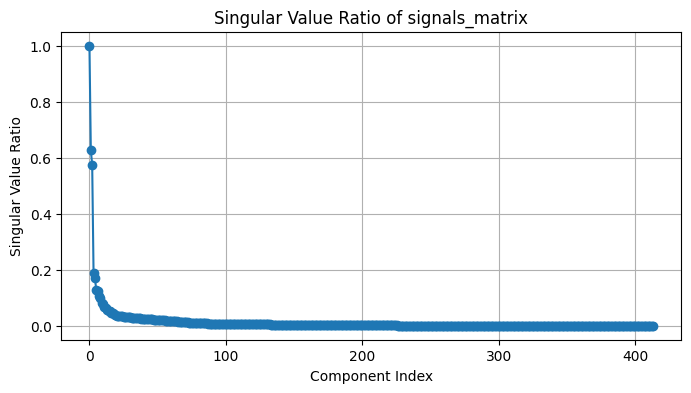

In [ ]:
# Remove columns with any NaN values before SVD
signals_matrix_clean = signals_matrix[:, ~np.isnan(signals_matrix).any(axis=0)]

# Perform Singular Value Decomposition (SVD) on the cleaned signals_matrix
U, S, VT = np.linalg.svd(signals_matrix_clean, full_matrices=False)

# Compute the singular value ratio (each singular value divided by the first)
singular_value_ratio = S / S[0]

# Plot the singular value ratio
plt.figure(figsize=(8, 4))
plt.plot(singular_value_ratio, marker='o')
plt.title('Singular Value Ratio of signals_matrix')
plt.xlabel('Component Index')
plt.ylabel('Singular Value Ratio')
plt.grid(True)
plt.show()